# Optimización de la distribución de sustentación en un semiala

Este es el archivo principal de la implementación. **No es necesario ejecutarlo, pues ya se muestran los resultados debajo del código.** El código utilizado para esta implementación se encuentra en la carpeta `src`, con el siguiente desglose:
- La carpeta `airplane` contiene la clase con todos los métodos requeridos por la aeronave
- La carpeta `kernel` contiene el código de fortran de Gauss-Chebyshev

En primer lugar, se implementan las librerias genericas que se utilizan

In [1]:
import numpy as np
from scipy import optimize as opt


#### SE DEBE ASEGURAR QUE SE ESTA USANDO COMO DIRECTORIO PRINCIPAL EL DE LA CARPETA DEL REPOSITORIO. EN CASO DE PROBLEMAS, CORRER EL SIGUIENTE CODIGO ####
#import os
#print(os.getcwd())
#os.chdir('..') # Descomentar si no se esta en la carpeta correcta y modificar para que lo este


A continuacion, se importa el codigo creado de `Airplane`

In [2]:
from src import Airplane

Creacion del objeto del ala

In [3]:
pedro = Airplane(1000, # Envergadura
                 15, # Envergadura
                 )

La funcion `lift_difference` permite calcular la diferencia entre el lift que genera el ala y la fuerza generada en valor absoluto. Cuanto mayor sea este valor, mas proporcion de fuerza hacia abajo se esta realizando y, por tanto, menos eficiente es el ala, pues está gastando energia en generar fuerza hacia abajo en lugar de hacia arriba.

In [4]:
def lift_difference(a):
    return abs((pedro.lift_poli(a) - pedro.abs_lift(a))/(pedro.abs_lift(a)+1))

Por ejemplo, en caso de utilizar el polinomio x^2 + 2x, se obtiene lo siguiente:

In [5]:
print(lift_difference([1, 2]))

0.04294156977359735


En la optimizacion, se pueden controlar principalmente los siguientes parametros

In [6]:
grado = 6 # Gradio del polinonio g(x) en la funcion f(x) = sqrt(1-x^2) * g(x)

lift = pedro.weight/2 # [N] Fuerza de sustentacion objetivo en el ala (la mitad del peso del avion)
print(lift)
lift_tol = 0.1 # Tolerancia de la fuerza de sustentacion

negative_lift_tol = 0.1 # Tolerancia de la fuerza de sustentacion negativa

4900.0


El siguiente código es el principal. Se encarga de llevar a cabo la optimización. Aquí se define la función objetivo, la limitación de sustentación, así como la restricción de lift negativo. Se imprime en consola los coeficientes del polinomio obtenidos.

In [13]:
# Funcion objetivo, minimizar el momento de la fuerza de sustentacion
def objective(a):
    return abs(pedro.moment_poli(a))

# Se restringe la fuerza de sustentacion a un rango de tolerancia
lift_target = opt.NonlinearConstraint(lambda a: pedro.lift_poli(a), lift*(1-lift_tol), lift*(1+lift_tol))

# Se restringe la cantidad de fuerza de sustentacion negativa a un rango de tolerancia
negative_lift = opt.NonlinearConstraint(lift_difference, 0, negative_lift_tol)


a0 = np.zeros(grado)
print(f"Coeficientes inciales: {a0}")
print("-------------------------")

res = opt.minimize(objective, a0, method='SLSQP', constraints=[lift_target, negative_lift], options={'disp': True})

res = res.x
print("-------------------------")
print(f"Coeficientes finales: {res}")


Coeficientes inciales: [0. 0. 0. 0. 0. 0.]
-------------------------
Iteration limit reached    (Exit mode 9)
            Current function value: 3411.528441650522
            Iterations: 100
            Function evaluations: 758
            Gradient evaluations: 100
-------------------------
Coeficientes finales: [   154.43425592  -3505.50421377   1733.63752969  24790.40596871
 -35497.4002215    7488.97244749]


Finalmente, se muestra el lift obtenido, el momento en la raiz, la grafica del lift en funcion de la posicion y la distribución del momento generado en la raiz

Lift total obtenido: 4410.011732222932 N
Momento en la raiz: 3411.528441650522 N*m


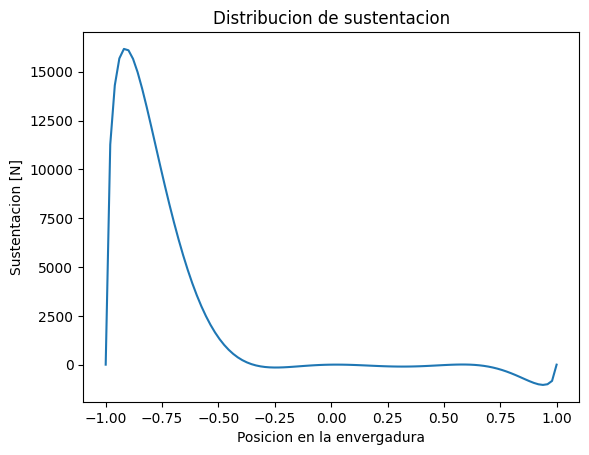

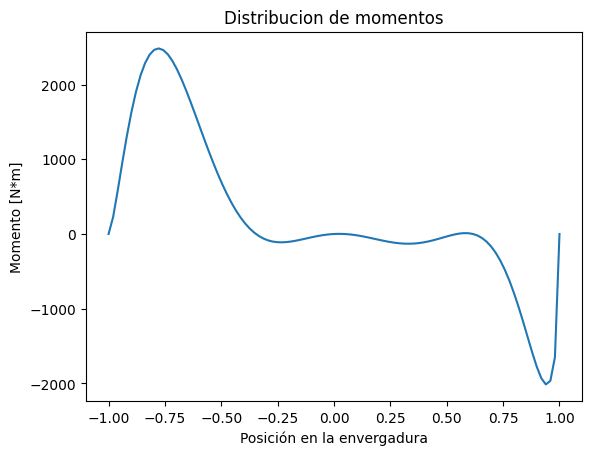

In [14]:
print(f"Lift total obtenido: {pedro.lift_poli(res)} N")
print(f"Momento en la raiz: {pedro.moment_poli(res)} N*m")


pedro.plot_lift(res)
pedro.plot_moment(res)

## Comparativa de velocidad de ejecucion

Ejemplo de como se llama a una funcion de fortran para calcular los nodos de chebyshev

In [9]:
from src import gauss_chebyshev as gc # Esto llama al modulo de kernel de gauss chebyshev
from time import time
import math

Se realiza la comparacion con el numero de ejecuciones mostradas

In [15]:
ejecuciones = 6000000

***Usando codigo de Fortran implementado en Python***

In [17]:
t0 = time()
gc.chebyshev_nodes(ejecuciones)
print("Tiempo de ejecución: ", time()-t0)

Tiempo de ejecución:  0.1963789463043213


Usando un ***bucle de Python*** y la ***libreria math*** (hecha en C), se ve que es extremadamente lento, aun realizando las operaciones matemáticas en C. Esto muestra la baja velocidad de los bucles de Python

In [ ]:
def chebyshev_nodes(n):
    """
    Cálculo de los nodos y pesos de Chebyshev (versión sin NumPy).
    
    :param n: número de nodos
    :return: (x, w) tupla de dos listas de longitud n
             x -> nodos de Chebyshev
             w -> pesos (constantes en este caso)
    """
    x = []
    w = []
    
    for i in range(1, n + 1):
        # x(i) = cos((2*i - 1)*pi / (2*n))
        x_val = math.cos((2.0 * i - 1.0) * math.pi / (2.0 * n))
        x.append(x_val)
        
        # w(i) = pi / n
        w_val = math.pi / n
        w.append(w_val)
    
    return x, w

# Ejemplo de uso
if __name__ == "__main__":
    t0 = time()
    x, w = chebyshev_nodes(ejecuciones)
    print("Tiempo de ejecución: ", time()-t0)


Tiempo de ejecución:  0.8699560165405273
